<a href="https://colab.research.google.com/github/034adarsh/Stock-Price-Prediction-Using-LSTM/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the required libraries

---



In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import ipywidgets as widgets
from IPython.display import display

In [60]:
window_slider = widgets.IntSlider(
    value=100,
    min=10,
    max=200,
    step=10,
    description='Window Size:',
    continuous_update=False
)

train_split_slider = widgets.FloatSlider(
    value=0.8,
    min=0.5,
    max=0.9,
    step=0.05,
    description='Train Split:',
    continuous_update=False
)

display(window_slider, train_split_slider)

IntSlider(value=100, continuous_update=False, description='Window Size:', max=200, min=10, step=10)

FloatSlider(value=0.8, continuous_update=False, description='Train Split:', max=0.9, min=0.5, step=0.05)

# Define start day to fetch the dataset from the yahoo finance library

---



In [61]:
df = pd.read_csv("StockHistoricalData/INTEL.csv")
print(df.head())


           Date   Open   High    Low  Close  Adj Close      Volume
0  Feb 27, 2026  44.46  46.56  44.40  45.61      45.61  79,231,400
1  Feb 26, 2026  46.77  46.95  44.39  45.46      45.46  71,457,500
2  Feb 25, 2026  46.09  46.97  45.08  46.88      46.88  75,645,300
3  Feb 24, 2026  44.10  46.60  43.54  46.12      46.12  98,872,300
4  Feb 23, 2026  44.09  44.55  43.18  43.63      43.63  57,130,900


In [62]:
df = df.drop(['Date','Adj Close'], axis = 1)

first = df.iloc[:1]
reversed_rest = df.iloc[1:][::-1].reset_index(drop=True)
df = pd.concat([first, reversed_rest], ignore_index=True)

df['Volume'] = (
    df['Volume']
        .astype(str)
        .str.replace(',', '', regex=False)
)

df = df[df['Volume'] != 'nan']
df['Volume'] = df['Volume'].astype(int)

df.head()

,Open,High,Low,Close,Volume
0,44.46,46.56,44.40,45.61,79231400
1,61.72,63.08,61.65,62.88,28495400
2,62.80,63.14,61.11,61.24,23320000
3,60.64,61.52,59.70,59.90,28740400
4,59.83,60.24,57.91,58.33,40210400


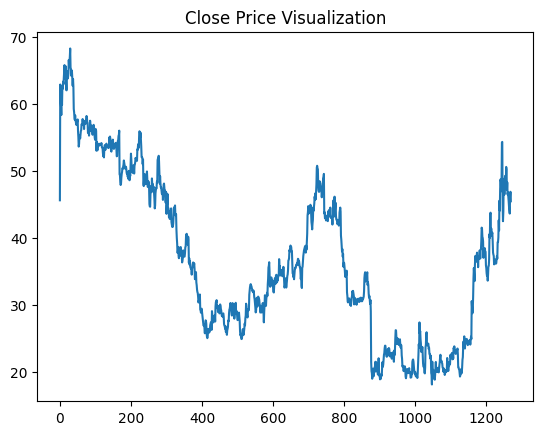

In [63]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

# Plotting moving averages of 100 day

---



Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

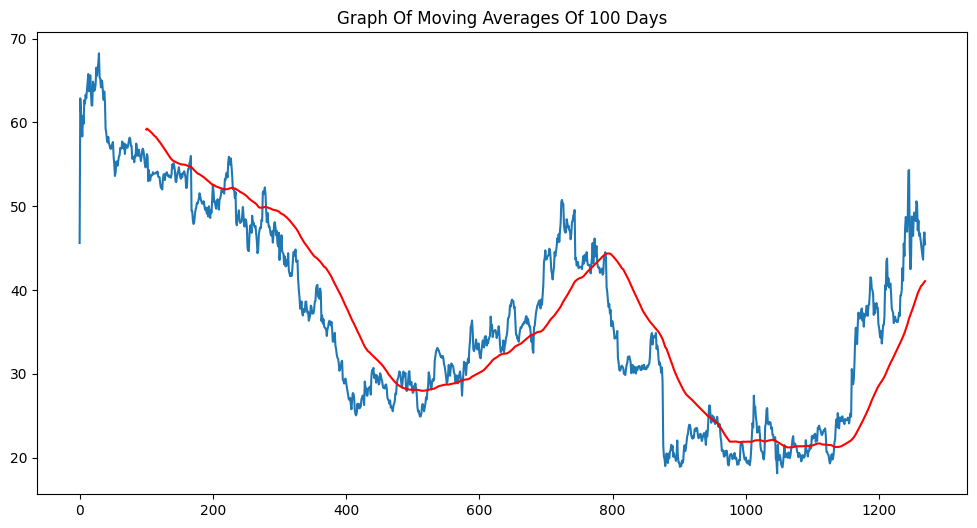

In [64]:
ma100 = df.Close.rolling(100).mean()
ma100

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [65]:
split_index = int(len(df) * 0.8)
train = df[:split_index]
test = df[split_index:]

In [66]:
train.head

<bound method NDFrame.head of        Open   High    Low  Close     Volume
0     44.46  46.56  44.40  45.61   79231400
1     61.72  63.08  61.65  62.88   28495400
2     62.80  63.14  61.11  61.24   23320000
3     60.64  61.52  59.70  59.90   28740400
4     59.83  60.24  57.91  58.33   40210400
...     ...    ...    ...    ...        ...
1014  25.56  26.12  24.48  26.09  144939600
1015  25.96  26.29  24.84  24.87  111630900
1016  24.55  24.80  23.62  24.27   91358100
1017  24.21  24.28  22.77  22.99   88886500
1018  23.25  23.82  23.21  23.52   67449300

[1004 rows x 5 columns]>

In [67]:
test.head

<bound method NDFrame.head of        Open   High    Low  Close     Volume
1019  23.70  24.40  23.07  23.09   97871900
1020  23.02  24.44  22.64  23.73  104133800
1021  25.00  25.04  22.52  22.74  141348700
1022  22.54  22.63  20.76  21.33  152182200
1023  21.33  21.36  20.18  20.81  127219300
...     ...    ...    ...    ...        ...
1265  43.89  44.39  42.88  44.11   90743600
1266  44.09  44.55  43.18  43.63   57130900
1267  44.10  46.60  43.54  46.12   98872300
1268  46.09  46.97  45.08  46.88   75645300
1269  46.77  46.95  44.39  45.46   71457500

[251 rows x 5 columns]>

# Using MinMax scaler for normalization of the dataset

---



In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_close = train.iloc[:, 3:4].values
test_close = test.iloc[:, 3:4].values

train_close

array([[45.61],
       [62.88],
       [61.24],
       ...,
       [24.27],
       [22.99],
       [23.52]], shape=(1004, 1))

In [69]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[0.54121936],
       [0.89102694],
       [0.85780839],
       ...,
       [0.10897306],
       [0.08304638],
       [0.09378165]], shape=(1004, 1))

In [70]:
data_testing_array = scaler.transform(test_close)
data_testing_array

array([[ 0.08507191],
       [ 0.09803524],
       [ 0.07798258],
       [ 0.04942273],
       [ 0.03889001],
       [ 0.0376747 ],
       [ 0.03544663],
       [ 0.02106542],
       [ 0.01802714],
       [ 0.03625684],
       [ 0.09742759],
       [ 0.10451691],
       [ 0.13773547],
       [ 0.14239417],
       [ 0.10593478],
       [ 0.10269394],
       [ 0.10877051],
       [ 0.1079603 ],
       [ 0.1075552 ],
       [ 0.09175613],
       [ 0.09580717],
       [ 0.07737492],
       [ 0.07737492],
       [ 0.06400648],
       [ 0.06258862],
       [ 0.07170346],
       [ 0.01944501],
       [ 0.01377355],
       [-0.01539396],
       [ 0.05347377],
       [ 0.02005266],
       [ 0.01721693],
       [ 0.02876241],
       [ 0.01944501],
       [ 0.00688677],
       [ 0.00081021],
       [-0.00101276],
       [ 0.01255823],
       [ 0.03443387],
       [ 0.05266356],
       [ 0.02349605],
       [ 0.03281345],
       [ 0.02937006],
       [ 0.02450881],
       [ 0.02207819],
       [ 0

In [71]:
x_train = []
y_train = []
window_size = 100

for i in range(window_size, data_training_array.shape[0]):
    x_train.append(data_training_array[i-window_size:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [72]:
x_train

array([[[0.54121936],
        [0.89102694],
        [0.85780839],
        ...,
        [0.73080818],
        [0.72412396],
        [0.73627709]],

       [[0.89102694],
        [0.85780839],
        [0.8306664 ],
        ...,
        [0.72412396],
        [0.73627709],
        [0.75632975]],

       [[0.85780839],
        [0.8306664 ],
        [0.79886571],
        ...,
        [0.73627709],
        [0.75632975],
        [0.75086085]],

       ...,

       [[0.10168118],
        [0.09256634],
        [0.07696982],
        ...,
        [0.13834312],
        [0.14583755],
        [0.12112619]],

       [[0.09256634],
        [0.07696982],
        [0.07089326],
        ...,
        [0.14583755],
        [0.12112619],
        [0.10897306]],

       [[0.07696982],
        [0.07089326],
        [0.06826008],
        ...,
        [0.12112619],
        [0.10897306],
        [0.08304638]]], shape=(904, 100, 1))

In [73]:
x_test = []
y_test = []

for i in range(window_size, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i-window_size:i])
    y_test.append(data_testing_array[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [74]:
x_test.shape

(151, 100, 1)

# Training the ML model (LSTM)

---



In [75]:
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf
import joblib

class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, progress_bar, output_area):
        super().__init__()
        self.epochs = epochs
        self.progress_bar = progress_bar
        self.output_area = output_area

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.value = epoch + 1
        
        with self.output_area:
            self.output_area.clear_output(wait=True)
            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Loss: {logs['loss']:.6f}")

In [76]:
def train_model(window_size, train_split, epochs):

    # UI elements
    progress_bar = widgets.IntProgress(
        value=0,
        min=0,
        max=epochs,
        description='Training:',
        bar_style='info'
    )

    training_output = widgets.Output()
    plot_output = widgets.Output()

    display(progress_bar)
    display(training_output)
    display(plot_output)

    split_index = int(len(df) * train_split)
    train = df[:split_index]
    test = df[split_index:]

    scaler = MinMaxScaler(feature_range=(0,1))

    train_close = train.iloc[:, 3:4].values
    test_close = test.iloc[:, 3:4].values

    data_training_array = scaler.fit_transform(train_close)
    data_testing_array = scaler.transform(test_close)

    # Create sequences
    x_train, y_train = [], []
    for i in range(window_size, len(data_training_array)):
        x_train.append(data_training_array[i-window_size:i])
        y_train.append(data_training_array[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_test, y_test = [], []
    for i in range(window_size, len(data_testing_array)):
        x_test.append(data_testing_array[i-window_size:i])
        y_test.append(data_testing_array[i, 0])
    x_test, y_test = np.array(x_test), np.array(y_test)

    # Build model
    model = Sequential([
        tf.keras.Input(shape=(x_train.shape[1], 1)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    progress_callback = TrainingProgressCallback(
        epochs, progress_bar, training_output
    )

    model.fit(
        x_train,
        y_train,
        epochs=epochs,
        verbose=0,
        callbacks=[progress_callback]
    )

    progress_bar.bar_style = 'success'
   
    model.save("keras_model.h5")
    print("Model saved as keras_model.h5")
    joblib.dump(scaler, "scaler.save")
    print("Scaler saved as scaler.save")

    # Predictions
    y_pred = model.predict(x_test, verbose=0)

    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Show plot inside controlled output area
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.figure(figsize=(10,5))
        
        plt.plot(y_test, label="Actual")
        plt.plot(y_pred, label="LSTM")
        
        plt.xlabel("Day")
        plt.ylabel("Price (USD)")
        plt.title("Stock Price Prediction")
        
        plt.legend()
        plt.show()

In [77]:
window_slider = widgets.IntSlider(
    min=10, max=200, step=10, value=100,
    description="Window Size:"
)

train_split_slider = widgets.FloatSlider(
    min=0.5, max=0.9, step=0.05, value=0.8,
    description="Train Split:"
)

epoch_slider = widgets.IntSlider(
    min=5, max=50, step=5, value=20,
    description="Epochs:"
)

run_button = widgets.Button(
    description="Train Model",
    button_style='success'
)

display(window_slider, train_split_slider, epoch_slider, run_button)

def on_button_click(b):
    train_model(
        window_slider.value,
        train_split_slider.value,
        epoch_slider.value
    )

run_button.on_click(on_button_click)

IntSlider(value=100, description='Window Size:', max=200, min=10, step=10)

FloatSlider(value=0.8, description='Train Split:', max=0.9, min=0.5, step=0.05)

IntSlider(value=20, description='Epochs:', max=50, min=5, step=5)

Button(button_style='success', description='Train Model', style=ButtonStyle())

IntProgress(value=0, bar_style='info', description='Training:', max=30)

Output()

Output()

Model saved as keras_model.h5


Loading saved model...


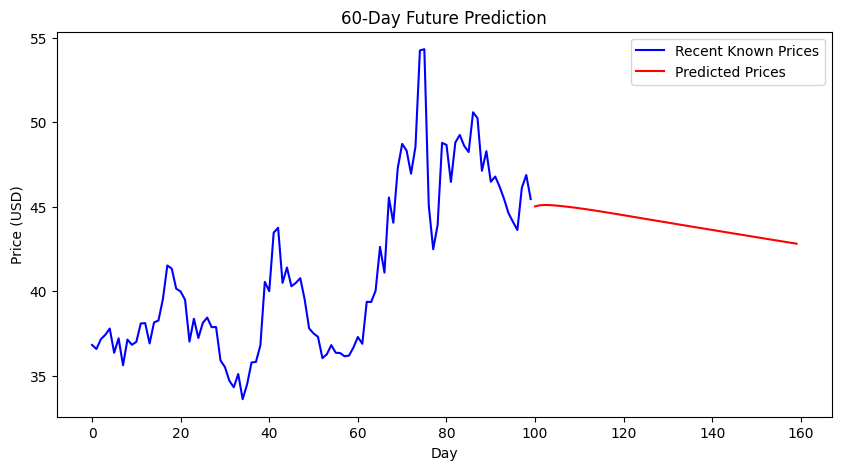

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model

days_ahead = int(input("Enter number of days to predict ahead: "))

model_path = "keras_model.h5"
scaler_path = "scaler.save"

if not os.path.exists(model_path):
    print("ERROR: keras_model.h5 not found. Train the model first.")
elif not os.path.exists(scaler_path):
    print("ERROR: scaler.save not found. Retrain model to save scaler.")
else:
    
    print("Loading model and scaler...")
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    window_size = model.input_shape[1]

    close_prices = df[['Close']].values
    scaled_data = scaler.transform(close_prices)

    last_window = scaled_data[-window_size:]
    current_window = last_window.copy()

    predictions = []

    for _ in range(days_ahead):
        input_data = current_window.reshape(1, window_size, 1)
        next_pred = model.predict(input_data, verbose=0)

        predictions.append(next_pred[0, 0])

        # Slide window forward
        current_window = np.vstack((current_window[1:], next_pred))

    predictions = np.array(predictions).reshape(-1,1)
    predicted_prices = scaler.inverse_transform(predictions).flatten()

    previous_days = days_ahead // 4
    recent_known = close_prices[-previous_days:].flatten() if previous_days > 0 else np.array([])

    plt.figure(figsize=(10,5))

    x_known = range(len(recent_known))
    x_pred = range(len(recent_known), len(recent_known) + len(predicted_prices))

    if previous_days > 0:
        plt.plot(x_known, recent_known, color='blue', label="Recent Known Prices")

    plt.plot(x_pred, predicted_prices, color='red', label="Predicted Prices")

    plt.xlabel("Day")
    plt.ylabel("Price (USD)")
    plt.title(f"{days_ahead}-Day Future Prediction")
    plt.legend()
    plt.show()